# Initial state identification for mouse embryonic fibroblasts

## Library imports

In [1]:
import sys

from scipy.sparse import load_npz

import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")
scv.settings.plot_prefix = ""

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / "realtime_kernel" / "mef").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

In [5]:
(DATA_DIR / "mef" / "results").mkdir(parents=True, exist_ok=True)

## Function definitions

## Data loading

In [6]:
adata = cr.datasets.reprogramming_schiebinger(DATA_DIR / "mef" / "reprogramming_schiebinger.h5ad")
adata = adata[adata.obs["serum"] == "True"].copy()

adata.obs["day"] = adata.obs["day"].astype(float)
adata.uns["cell_sets_colors"] = sns.color_palette("colorblind").as_hex()[: len(adata.obs["cell_sets"].cat.categories)]

adata

DEBUG: Loading dataset from `'/vol/storage/philipp/code/cellrank2_reproducibility/data/mef/reprogramming_schiebinger.h5ad'`


AnnData object with n_obs × n_vars = 165892 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'

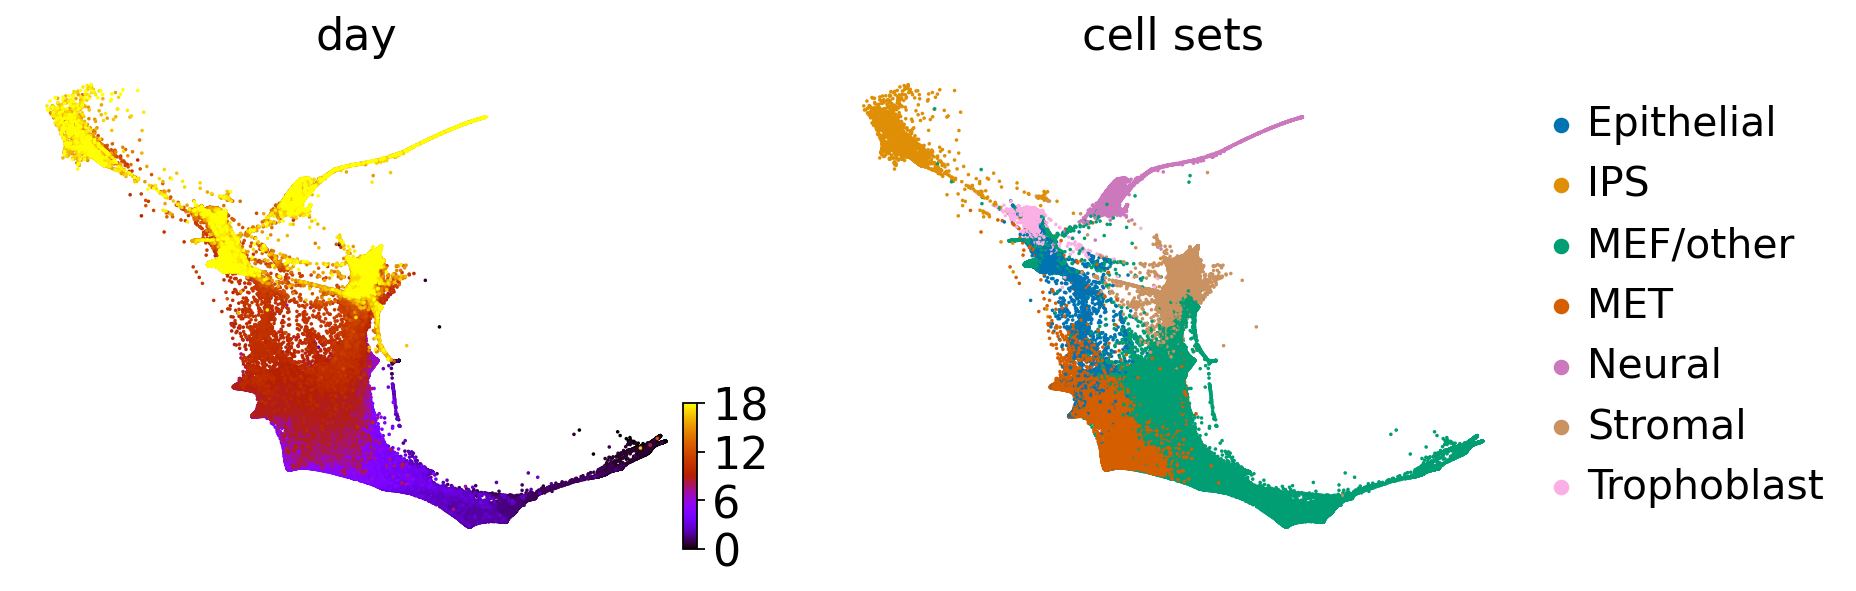

In [7]:
scv.pl.scatter(adata, basis="force_directed", c=["day", "cell_sets"], legend_loc="right", cmap="gnuplot")

## Data pre-processing

In [8]:
sc.pp.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:20)


In [9]:
sc.pp.neighbors(adata, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:02:54)


## Pseudotime construction

In [10]:
adata.obs["day"] = adata.obs["day"].astype(float).astype("category")

In [11]:
rtk = cr.kernels.RealTimeKernel.from_wot(adata, path=DATA_DIR / "mef" / "wot_tmaps", time_key="day")
rtk.transition_matrix = load_npz(DATA_DIR / "mef" / "transition_matrices" / "all_connectivities.npz")
rtk.transition_matrix = rtk.transition_matrix.T

Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.5', '.

## Terminal state estimation

In [12]:
estimator = cr.estimators.GPCCA(rtk)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:10)


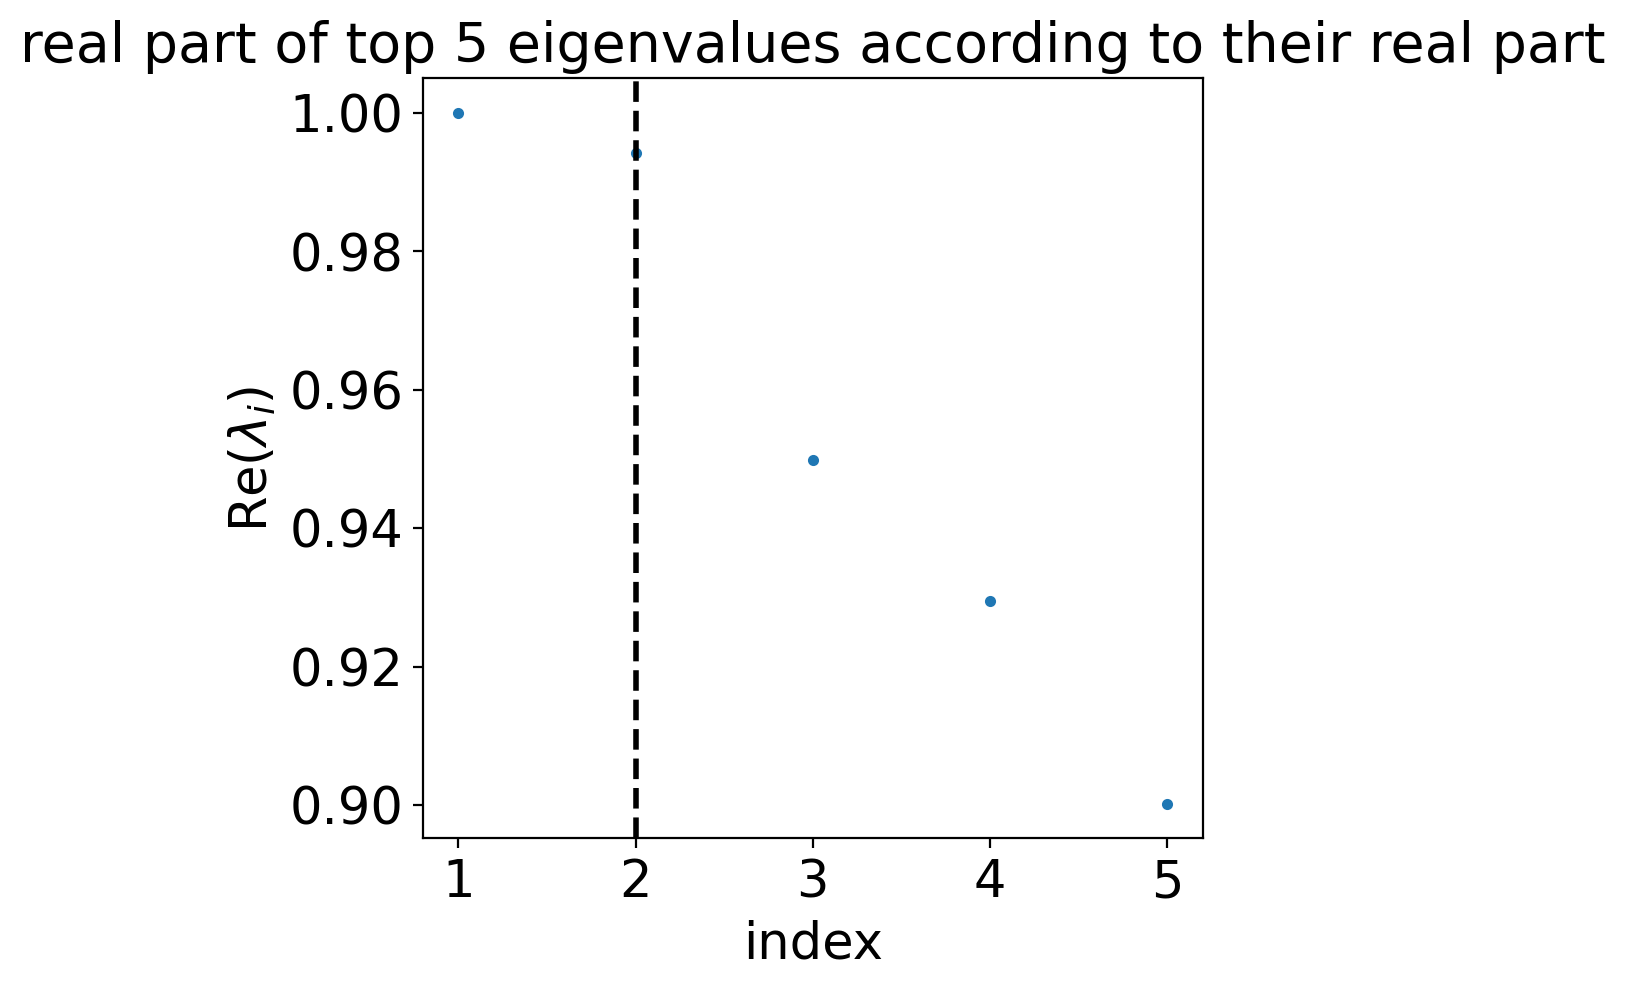

In [13]:
estimator.compute_schur(n_components=5)
estimator.plot_spectrum(real_only=True)

For 1 macrostate, stationary distribution is computed
Computing eigendecomposition of the transition matrix
DEBUG: Computing top `20` eigenvalues of a sparse matrix
DEBUG: Sorting eigenvalues by their real part
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:01:09)
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:01:09)


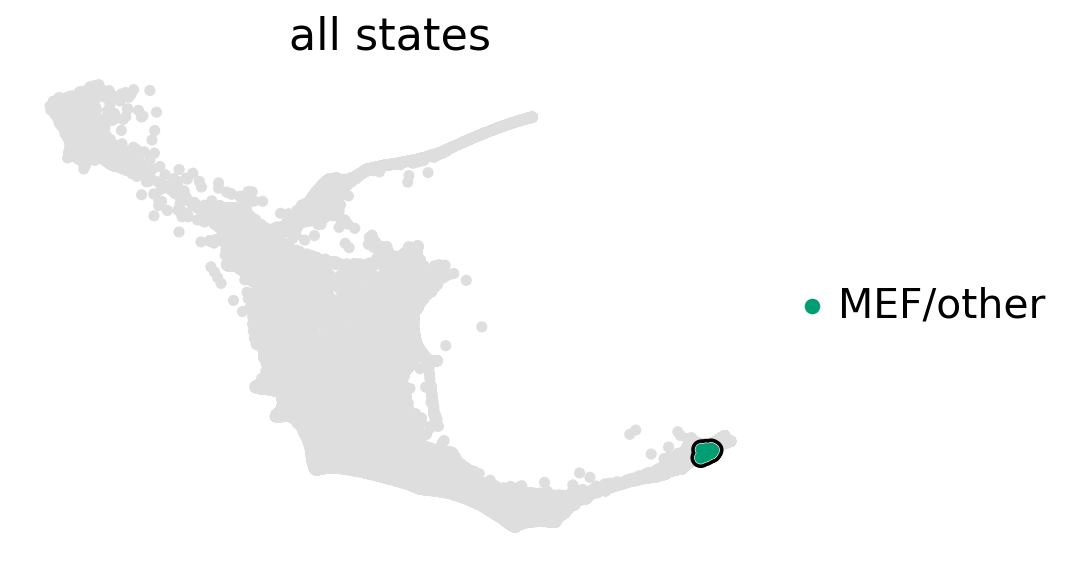

In [14]:
estimator.compute_macrostates(n_states=1, cluster_key="cell_sets")
estimator.plot_macrostates(which="all", basis="force_directed", legend_loc="right", s=100)